In [19]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

def unique_col_values(df):
    l = []
    index = df.columns
    columns = ['Uniques', 'DT', 'Nulls (%)', 'Null Count']
    for column in index:
        u = len(df[column].unique())
        c = len(df[column])
        n = df[column].isnull().sum()
        l.append([u, df[column].dtype, n/c*100, n])
        
    return pd.DataFrame(l,index=index,columns=columns).sort_values(by='Nulls (%)', ascending=False)   

In [2]:
test = pd.read_csv('data/test.csv')
print(test.shape)
train = pd.read_csv('data/train.csv')
print(train.shape)
train.head()

(418, 11)
(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
unique_col_values(train)

,Uniques,DT,Nulls (%),Null Count
Cabin,148,object,77.104377,687
Age,89,float64,19.865320,177
Embarked,4,object,0.224467,2
PassengerId,891,int64,0.000000,0
Survived,2,int64,0.000000,0
Pclass,3,int64,0.000000,0
Name,891,object,0.000000,0
Sex,2,object,0.000000,0
SibSp,7,int64,0.000000,0
Parch,7,int64,0.000000,0


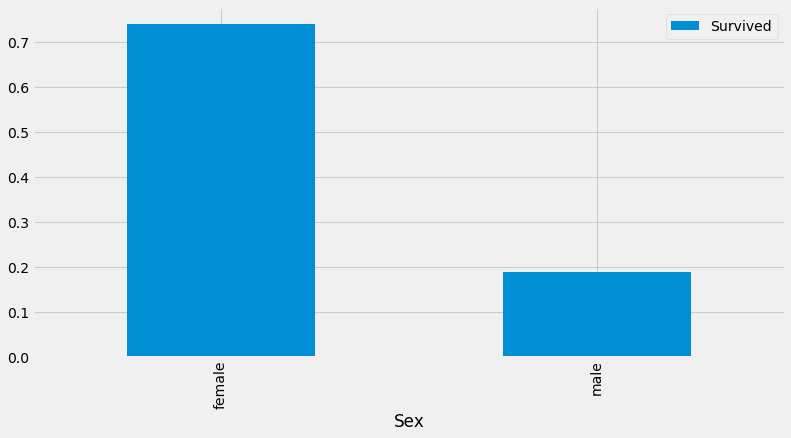

In [12]:
sex_pivot = train.pivot_table(index='Sex', values='Survived')
sex_pivot.plot.bar()

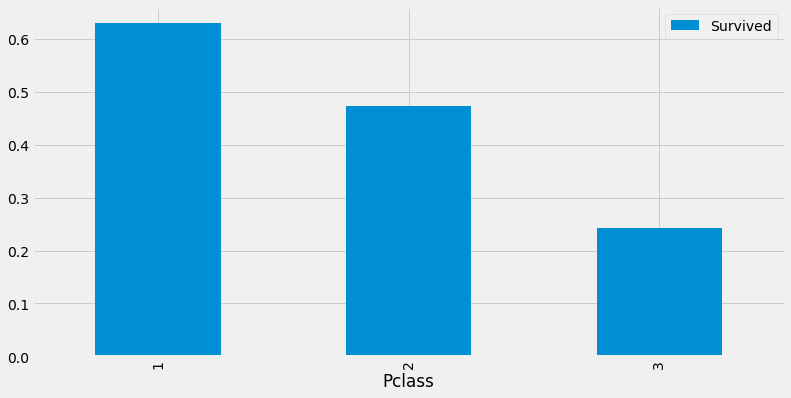

In [13]:
class_pivot = train.pivot_table(index='Pclass', values='Survived')
class_pivot.plot.bar()

In [7]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

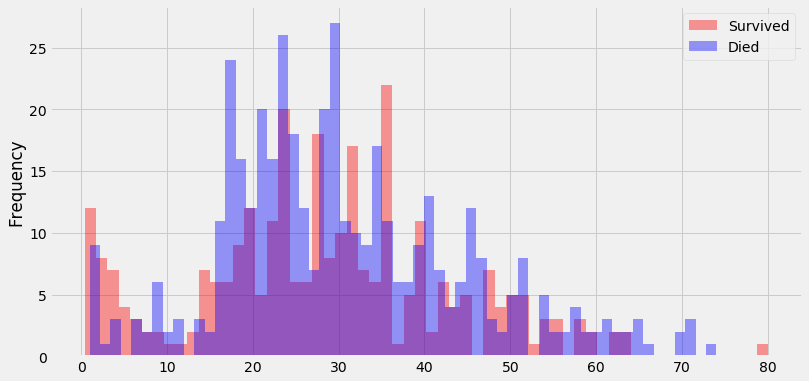

In [20]:
survived = train[train['Survived'] == 1]
died = train[train['Survived'] == 0]
survived['Age'].plot.hist(alpha = 0.4, color='r', bins=60)
died['Age'].plot.hist(alpha = 0.4, color='b', bins=60)
plt.legend(['Survived','Died'])

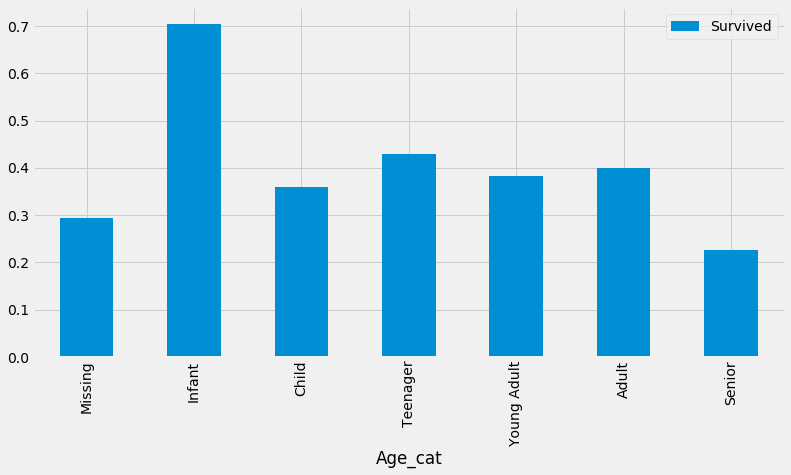

In [25]:
def process_age(df, cut_points, labels):
    df['Age'] = df['Age'].fillna(-1)
    df['Age_cat'] = pd.cut(df['Age'], cut_points, labels=labels)
    return df

cut_points = [-5,0,5,12,18,35,60,100]
labels = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

train = process_age(train, cut_points, labels)
test = process_age(test, cut_points, labels)

pivot_age_cat = train.pivot_table(index='Age_cat', values='Survived')
pivot_age_cat.plot.bar()

In [28]:
def create_dummies(df, column):
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df,dummies],axis=1)
    return df

for c in ["Pclass","Sex","Age_cat"]:
    train = create_dummies(train,c)
    test = create_dummies(test,c)

In [32]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [34]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_cat_Missing','Age_cat_Infant',
       'Age_cat_Child', 'Age_cat_Teenager',
       'Age_cat_Young Adult', 'Age_cat_Adult',
       'Age_cat_Senior']

lr.fit(train[columns], train['Survived'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
holdout = test # from now on we will refer to this
               # dataframe as the holdout data
    
from sklearn.model_selection import train_test_split

all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(all_X, all_y, test_size=0.2, random_state=0)

In [39]:
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
acc = accuracy_score(test_y, predictions)

print(acc)

0.810055865922


In [40]:
from sklearn.model_selection import cross_val_score

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
scores.sort()
acc = scores.mean()

print(scores)
print(acc)

[ 0.76404494  0.76404494  0.7752809   0.78651685  0.8         0.80681818
  0.80898876  0.81111111  0.83146067  0.87640449]
0.802467086596


In [42]:
lr = LogisticRegression()
lr.fit(all_X, all_y)
holdout_predictions = lr.predict(holdout[columns])

In [46]:
holdout_ids = holdout['PassengerId']
submission_df = {'PassengerId':holdout_ids,
                 'Survived':holdout_predictions}
submission = pd.DataFrame(submission_df)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [47]:
submission.to_csv('submission.csv',index=False)